In [1]:
%matplotlib inline


Region Growing Segmentation
===========================






In [2]:
'''Importing required packages'''

import SimpleITK as sitk
import numpy as np
from myshow import myshow, myshow3d
from downloaddata import fetch_data as fdata
from os import listdir
import matplotlib.pyplot as plt
import cv2
# from sklearn.metrics import jaccard_similarity_score
from skimage.measure import regionprops
from skimage.measure import label
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import closing, square
from skimage import exposure
import sys
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed

Loading Images 
--------------

In [3]:
scan_dir = 'lungOriginal/'
gt_dir = 'lungmasks/VESSEL12_01-20_Lungmasks/'
write_dir = 'results/'
#scan_dir = 'Data/all_image_scans/'
#gt_dir = 'Data/lungmasks/'
# scan_dir = 'D:/MAIA/MAIA-2nd Semester Cassino/Advanced Image Analysis/Dataset/Training_data/'
# gt_dir = 'D:/MAIA/MAIA-2nd Semester Cassino/Advanced Image Analysis/Dataset/Groundtruth/'
scan_files = [f for f in listdir(scan_dir) if 'mhd' in f]
gt_files = [f for f in listdir(scan_dir) if 'mhd' in f]
scan_files = np.sort(scan_files)
gt_files = np.sort(gt_files)


In [4]:
'''Selecting Patient (1 - 20)'''
patient_number= 20


In [5]:
'''Loading the original and the ground truth'''
patient_number = patient_number - 1
#img_T1 = sitk.ReadImage(scan_dir + scan_files[patient_number])
#ct_GT = sitk.ReadImage(gt_dir + gt_files[patient_number])


In [6]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    no_of_slices = ct_scan.shape[0]
    
    return itkimage, ct_scan, origin, spacing, no_of_slices

In [7]:
img_T1, orig_img , origin, spacing, no_of_slices = load_itk(scan_dir + scan_files[patient_number])
ct_GT_itk, ct_GT , origin_GT, spacing_GT, no_of_slices_GT = load_itk(gt_dir + gt_files[patient_number])



### Preprocessing

* The range of Pixel intensity values of the 3D images can range from -6000 to +4000 
* Images having intensities closer to the extremes have a gray/hazy look that are not consistent with other images
* After analysing the images and experimenting with image processing techniques, we found that clipping intensities at around 1000 on both positive and negatives sides resulted in similar images (without gray/haze) and good contrast 

(Note: Patients with gray/haze are: 4,7,10,11,12,13,14,16,19,20)



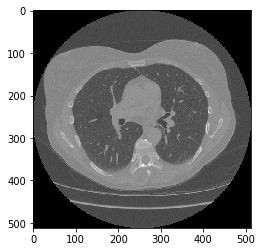

In [8]:
#displaying sample slice. If patient among the ones mentioned above, then a hazy image will be seen.
plt.imshow(orig_img[200], 'gray')

In [9]:
# image pre-processing:
'''If intensity value < -1000, then replace with -1000
    If intensity value > 1000, then replace with 1000 '''
orig_img[orig_img < -1000] = -1000
orig_img[orig_img > 1000] = 1000


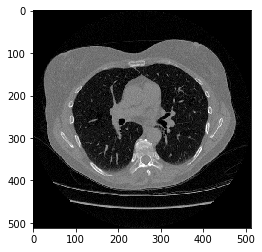

In [10]:
# sample slice after image pre-processing
plt.imshow(orig_img[200], 'gray')

In [11]:
'''Normalizing the intensity values'''
# converting the intensity values from range [-1000, 1000] to [0,255]
#To visualize the labels image in RGB needs a image with 0-255 range
img_T1 = sitk.GetImageFromArray(orig_img)
img_T1 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)



##### Result at this stage:
Summary upto this stage:
* Read patient images from file
* Pre-processed the image to remove haze/grayness
* Normalized them to range [0-255]

Output
* A pre-processed image

Seed selection
--------------



* Since our approach uses 3D Region Growing, it requires a seed as the starting point to grow. Therefore, finding a seed automatically for each patient is an important step.
* Below are functions that help in finding an appropriate seed 

Steps to find the seed:
* take a random slice from the 3D image (we chose one at about 75% from the first slice since it had best coverage of the lung)
* binarize the slice [function: clean_slice()]
* find the regions in the binary image to remove unwanted objects (remaining objects should be lungs) [function: find_regions()]
* using the regions, find the approximate geometric center of each lung as the seed [function: find_seed()] 

In [12]:
'''
Gaussian Smoothing + Otsu's Binarization

This function is used to return a clean binarized image when given a 2D slice from the original image

'''
def clean_slice(slice2D):
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(slice2D,(5,5),0)
    ret, th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5),np.uint8) #square image kernel used for erosion
    
    opening_ = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
    closing_ = cv2.morphologyEx(opening_, cv2.MORPH_CLOSE, kernel) #this is for further removing small noises and holes in the image
        
    return closing_


In [13]:
'''Used to find the regions the lungs and remove unwanted objects '''
def find_region(slice2D):
    
    thresh = threshold_otsu(slice2D)
    bw = closing(slice2D > thresh, square(3))
    
    # remove artifacts connected to image border
    cleared = clear_border(bw)
    
    # label image regions
    label_image = label(cleared)
    
    thresh = ((label_image > 0).astype('uint8')) * 255
    
    return thresh


In [14]:
'''Function to return 2 seeds, one at an approximate center of each lung'''
'''
    img_arrary_3: input 3D array of the patient 
    slice_fraction: slice from which seed is selected
    vert_fract: flexibility to move the seed in the vertical direction
    horiz_fract: flexibility to move the seed in the horizontal direction
    larger_contour_offset_fract: when both lungs are connected (one component), the geometrical center is outside the 
                                 lung region, more specifically in the area between the lungs. We detect such a case 
                                 by finding area of the object, and if it exceeds a certain threshold, we know now 
                                 it is the case, and find the seed appropriately.
'''

def find_seed(img_array_3D, slice_fraction, vert_fract, horiz_fract, larger_contour_offset_fract = 0): 
    
    z_axis = round(img_array_3D.shape[0] * slice_fraction)
    
    img_2D = img_array_3D[z_axis,:,:]
    img_2D_255 = (img_2D/256).astype('uint8')

    clean_slice1 = clean_slice(img_2D_255)
    clean_slice2 = find_region(clean_slice1)
    
    rgb_slice = cv2.cvtColor(img_2D_255, cv2.COLOR_GRAY2RGB)
    
#    contours, hierarchy = cv2.findContours(clean_slice2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    new, contours, hierarchy = cv2.findContours(clean_slice2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    #    contours are saved in increasing order of sizes. so to get larger ones, take the last
    cnt_len = len(contours)
    contour_img = cv2.drawContours(rgb_slice, contours, cnt_len - 1, (255,0,0), 4)
    
    x_coord = contours[cnt_len - 1][:,:,0]
    y_coord = contours[cnt_len - 1][:,:,1]  
    
    x_min = np.min(x_coord)
    y_min = np.min(y_coord)
    
    x_max = np.max(x_coord)
    y_max = np.max(y_coord)
    
    #if the width of the found object is large i.e. area greater than 40% (connected lungs)
    if (x_max - x_min)/(img_2D.shape[0]) > 0.4:
        x_marker = int((x_max - x_min) * (horiz_fract * larger_contour_offset_fract) + x_min) 
        y_marker = int((y_max - y_min) * vert_fract + y_min)
    
    else:    
        x_marker = int((x_max - x_min) * horiz_fract + x_min)
        y_marker = int((y_max - y_min) * vert_fract + y_min)
        
    contour_img_marker = cv2.circle(contour_img,(x_marker, y_marker), 3, (0,0,255), 7)
#    show_slice(contour_img_marker)
    
    seed_1 = (x_marker, y_marker, z_axis)
    
    # to find 2nd seed, mirror the 1st seed over the y-axis:
    x_length, y_length = (512, 512)
    
    mid_point = int(x_length / 2)
    
    if x_marker < mid_point :
        #left side seed
        diff = mid_point - x_marker
        seed_2_x = mid_point + diff
    else:
        #right side seed
        diff = x_marker - mid_point
        seed_2_x = mid_point - diff
   
    seed_2 = (seed_2_x, y_marker, z_axis) 
    
    return seed_1, seed_2, contour_img_marker
    

In [15]:
#calling function to return 2 seed to be used for region growing
seed_1, seed_2, seed_img = find_seed(orig_img.copy(), 
                                     slice_fraction = 0.75, 
                                     vert_fract = 0.50, 
                                     horiz_fract = 0.50,
                                     larger_contour_offset_fract = 0.4) 

/home/patricia/anaconda3/envs/aia/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


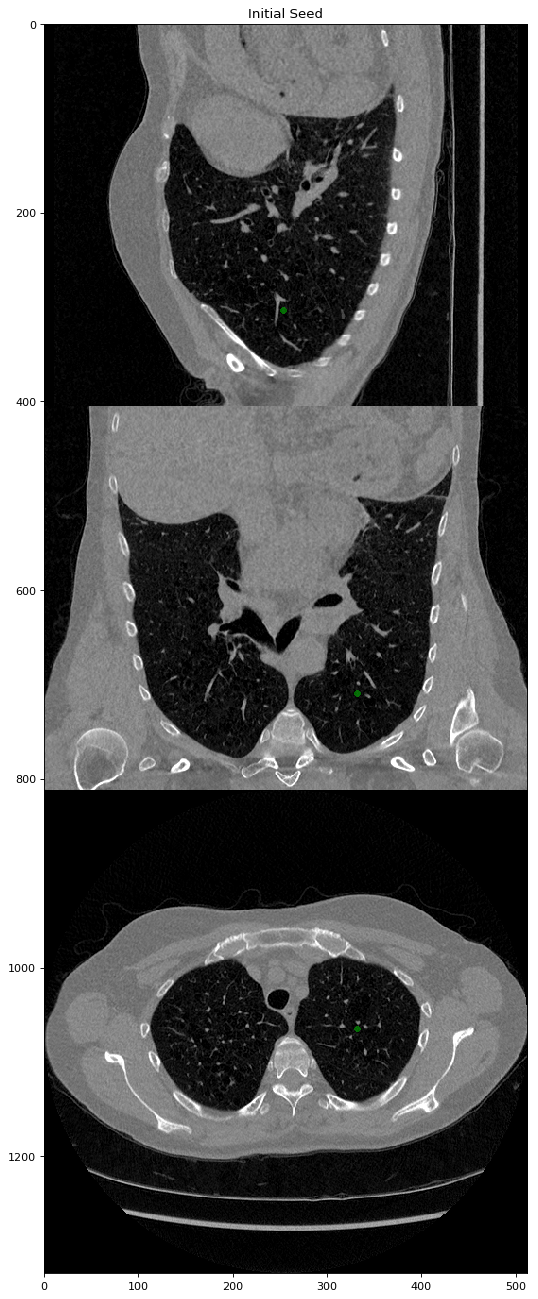

In [16]:
#Displaying only one of the two seeds. 
seed = seed_1
seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[seed] = 1


seg = sitk.BinaryDilate(seg, 3)

myshow3d(sitk.LabelOverlay(img_T1, seg),
         xslices=range(seed[0], seed[0]+1), yslices=range(seed[1], seed[1]+1),
         zslices=range(seed[2], seed[2]+1), title="Initial Seed")



In [17]:
'''Getting the intensity level value from Otsu's thresholding '''
def intensity_threshold(img):
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    seg = otsu_filter.Execute(img)
    threshold = otsu_filter.GetThreshold()
    return threshold
threshold = intensity_threshold(img_T1)

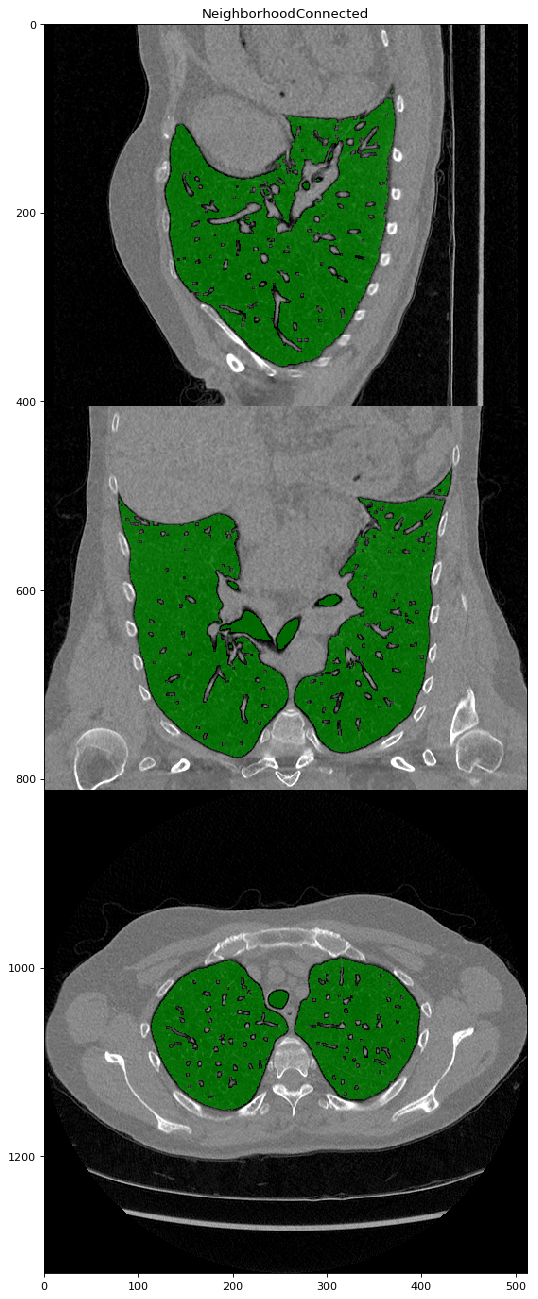

In [18]:
'''Applying the 3D region growing algorithm: Neighborhood Connected'''
seg_conf = sitk.NeighborhoodConnected(img_T1, seedList=(seed_1,seed_2),
                                    lower=0, upper=threshold+5)

img_array = sitk.GetArrayFromImage(seg_conf)
img_array = np.sum(img_array) #calculate the numbers of white pixels of the mask image(area). 


#If the area is greater than a threshold then it means that the mask contains also the background(PATIENT 13)
if img_array > 60000000:
    seg_conf = sitk.NeighborhoodConnected(img_T1, seedList=(seed_1,seed_2),
                                    lower=1, upper=threshold+5)
    myshow3d(sitk.LabelOverlay(img_T1, seg_conf),
         xslices=range(seed[0], seed[0]+1), yslices=range(seed[1], seed[1]+1),
         zslices=range(seed[2], seed[2]+1), title="NeighborhoodConnected")

myshow3d(sitk.LabelOverlay(img_T1, seg_conf),
         xslices=range(seed[0], seed[0]+1), yslices=range(seed[1], seed[1]+1),
         zslices=range(seed[2], seed[2]+1), title="NeighborhoodConnected")


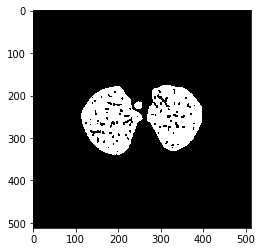

In [19]:
segmentation = sitk.GetArrayFromImage(seg_conf)

# print(jaccard(segmentation.flatten(),ct_GT.flatten()))
plt.imshow(segmentation[300], cmap = 'gray')
# plt.xticks([])
# plt.yticks([])
# plt.savefig('img_after_3D.png')

##### Result at this stage:

Summary upto this stage:
* Found the two needed seeds for applying region growing algorithm
* Intensity value found by Otsu that will be use in region growing algorithm 
* Region growing algorithm

Output:

* A 3D array mask with the lungs and the trachea



Trachea removal by applying Watershed after 3D region growing
--------------


In [20]:
#JACCARD INDEX
def jaccard(img,gt):
    '''
    Calcutes the jaccard index
    Args:
        img: segmented image
        gt: ground truth of the corresponding image
    Returns:
        Calculated Jaccard Index
    '''
    x = np.asarray(img, np.bool) 
    y = np.asarray(gt, np.bool)
    inter = np.double(np.bitwise_and(x, y).sum()) 
    union = np.double(np.bitwise_or(x, y).sum())
    
    return inter/union 

def trachea_removal_watershed(segmentation):
    '''
    Trachea Removal using Watershed algorithm
    
    First it creates markers using distance transform, 
    then the seeds for trachea are removed from the marker and then 
    apply watershed using these internal markers    
    
    Args: 
        binary image of lung after 3D region growing
        
    Returns: 
        binary image of lung with no trachea
        
    '''
    #setup the marker
    markers = np.empty_like(segmentation)
    label_watershed = np.empty_like(segmentation)
    kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
    
    #select slices with trachea
    trachea_part = int(0.4 * segmentation.shape[0])
    
    #calculate distance trasnform
    D = ndimage.distance_transform_edt(segmentation)
    for i in range(segmentation.shape[0]):
        if(i >= trachea_part):
            localMax = peak_local_max(D[i], indices=False, min_distance=20,  labels=segmentation[i],
                                  num_peaks_per_label = 20)
            markers[i,:,:] = ndimage.label(localMax)[0]
            
            #remove seeds(markers) in the middle which has trachea
            markers[i,:,220:280] = 0   
            
            #apply watershed
            label_watershed[i,:,:] = watershed(-D[i], markers[i,:,:], mask=segmentation[i,:,:]) 
            label_watershed[i,:,:] = cv2.morphologyEx(np.uint16(label_watershed[i,:,:]), cv2.MORPH_CLOSE, kernel_rect)
        else:
            label_watershed[i,:,:] = segmentation[i,:,:]  
            label_watershed[i,:,:] = cv2.morphologyEx(np.uint16(label_watershed[i,:,:]), cv2.MORPH_CLOSE, kernel_rect)
    
    #binarize the output
    final_watershed = (label_watershed > 0) * 1
    final_watershed = final_watershed.astype('uint8')
    
    return final_watershed


In [22]:
final_watershed = trachea_removal_watershed(segmentation)


Text(0.5, 1.0, 'trachea removal image')

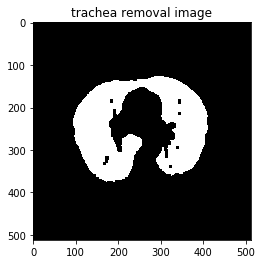

In [23]:
slice = 200

plt.imshow(final_watershed[slice],'gray')
plt.title('trachea removal image')

##### Result at this stage:

Summary upto this stage:
* Apply 2D watershed for trachea removing 

Output:

* A 3D array mask with the lungs


Fill the small holes
--------------

In [24]:
#fill all the holes(small and big)
def fillGaps(img):
    binarize = np.empty(img.shape)
    binarize = binarize.astype(np.uint8)
    for i in range(segmentation.shape[0]):   
        new,contour, hierarchy = cv2.findContours(img[i-1,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contour:
            cv2.drawContours(binarize[i-1,:,:],[cnt],0,255,-1)
    return binarize
fill_img = fillGaps(final_watershed)

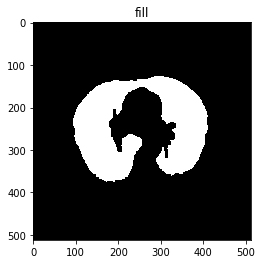

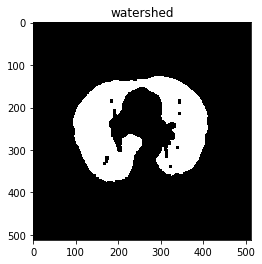

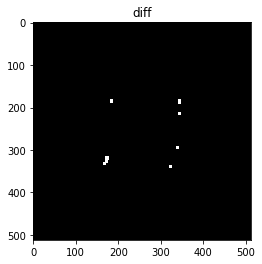

In [25]:
slice = 200;
plt.imshow(fill_img[slice],'gray')
plt.title('fill')
plt.show()


plt.imshow(final_watershed[slice],'gray')
plt.title('watershed')
plt.show()

#compute the difference
diff_img = final_watershed+fill_img
plt.imshow(diff_img[slice],'gray')
plt.title('diff')
plt.show()

In [26]:
'''To fill small holes and not big ones'''
def fill_small_holes(slice2D, fill_img_2D):   
    #finding the contours
    new, contours, hierarchy = cv2.findContours(slice2D,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#    contours, hierarchy = cv2.findContours(slice2D,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    area_thresh = 500
    
    new_contours = []
    
    for cnt in contours:
        cnt_area = cv2.contourArea(cnt)
        
        if cnt_area < area_thresh:
            new_contours.append(cnt)
    
    #filling the contours of small holes:    
    new_img = cv2.drawContours(slice2D, new_contours,-1,(0,0,0),-1)
    
    #subtracting the all_filled image with the new_img:
    final_slice = fill_img_2D - new_img    
    
    return final_slice

In [27]:
no_small_holes_3D = np.zeros(final_watershed.shape)

for num in np.arange(0, no_small_holes_3D.shape[0]):
    cleaned = fill_small_holes(slice2D = diff_img[num].copy(), fill_img_2D = fill_img[num].copy())    
    no_small_holes_3D[num, :, :] = cleaned

Post-processing
-----------

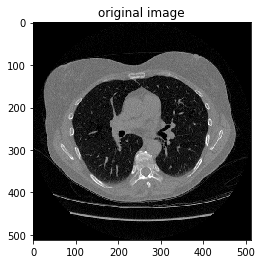

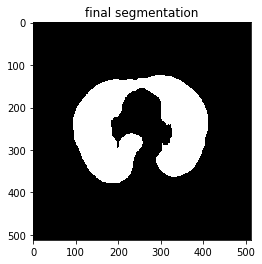

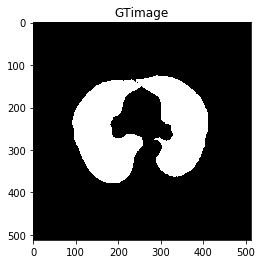

In [28]:
no_small_holes = no_small_holes_3D.astype('uint8')

kernel = np.ones((5,5), np.uint8)   
img_dilation = cv2.dilate(no_small_holes, kernel, iterations=1) 

kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(7,7))
img_close = cv2.morphologyEx(img_dilation, cv2.MORPH_CLOSE, kernel2)

kernel3 = np.ones((7,7), np.uint8)   
dil_img = cv2.dilate(img_close, kernel3, iterations=2) 
final_segmentation = cv2.erode(dil_img, kernel3, iterations=2)

plt.imshow(orig_img[slice],'gray')
plt.title('original image')
plt.show()

plt.imshow(final_segmentation[slice],'gray')
plt.title('final segmentation')
plt.show()
plt.imshow(ct_GT[slice],'gray')
plt.title('GTimage')
plt.show()

In [29]:
#Jaccard index for the patient
print(jaccard(final_segmentation.flatten(),ct_GT.flatten()))

0.9721649254703814


In [30]:
'''Save ITK image from Numpy 3D array'''
def save_itk(image, origin, spacing, filename):
    
    itkimage = sitk.GetImageFromArray(image, isVector=False)
    itkimage.SetSpacing(spacing)
    itkimage.SetOrigin(origin)
    sitk.WriteImage(itkimage, filename, True)

In [31]:
'''Numpy to SITK and write to file'''
save_itk(final_segmentation, origin, spacing, write_dir + scan_files[patient_number])


In [32]:
#trachea_watershed +dil + eros + closing + threshold+5
p1 = 0.9604103788005182
p2 = 0.9740296829054643
p3 = 0.9794695767806187
p4 = 0.9728885262253911
p5 = 0.9742722458649637
p6 = 0.9534227294310267
p7 = 0.9763746593125397
p8 = 0.9694882447603608
p9 = 0.9643071119640346
p10 = 0.9706692778556221
p11 = 0.9695912897118031
p12 = 0.9633988002861718
p13 = 0.9637200270433447
p14 = 0.9681355669703418
p15 = 0.9735094725891251
p16 = 0.9722575581742743
p17 = 0.9510224826603871
p18 = 0.9749195750786542
p19 = 0.9745373849275651
p20 = 0.9721649254703814
p = (p1+p2+p3+p4+p5+p6+p7+p8+p9+p10+p11+p12+p13+p14+p15+p16+p17+p18+p19+p20)/20
p

0.9689294758406293